In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd

Using TensorFlow backend.


In [2]:
# Set parameters here 
INPUT_SIZE = 256
mapping = {0:'normal', 1:'other'}
NUMCLASSES = len(mapping)
BATCH_SIZE = 16

folder = r'C:\Users\arung\OneDrive\Desktop\COVID 19 Chest Xray\nih'
covidfoler

In [3]:
from skimage import exposure

def preprocess(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    # Histogram Equalization
    #img_eq = exposure.equalize_hist(img)

    # Adaptive Equalization
    #img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
    
    return img_rescale


In [8]:
train_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_whitening=False,
                                zca_epsilon=1e-06,
                                rotation_range=0,
                                width_shift_range=0.0,
                                height_shift_range=0.0,
                                brightness_range=None,
                                shear_range=0.0,
                                zoom_range=0.0,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=False,
                                vertical_flip=False,
                                rescale=None,
                                preprocessing_function=preprocess,
                                data_format=None,
                                validation_split=0.2,
                                dtype=None,
                            )


In [9]:
df = pd.read_csv(folder + r'\allfiles.csv')
df = df[df.label!='pneumonia']
# This next line is to use only 10% of the data
df = df.sample(n = df.shape[0]//5)
print(df['label'].value_counts())

training_set = train_datagen.flow_from_dataframe(
                                            dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            validate_filenames=True
                                        )

validation_set = train_datagen.flow_from_dataframe( dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='validation',
                                            interpolation="nearest",
                                            validate_filenames=True
                                            )

normal    10161
other      7097
Name: label, dtype: int64
Found 13807 validated image filenames belonging to 2 classes.
Found 3451 validated image filenames belonging to 2 classes.


In [10]:
from keras.models import Sequential
import tensorflow as tf
from keras.layers import *
from keras.optimizers import *
#from sklearn.model_selection import train_test_split
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

model = Sequential()

model.add(InputLayer(input_shape=[INPUT_SIZE,INPUT_SIZE,3])) #keras will internally add batch dimension

model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=64,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(Conv2D(filters=32,kernel_size=3,strides=1,padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2,padding='same'))
model.add(Dropout(0.4))


model.add(Flatten())


model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(NUMCLASSES,activation='softmax'))


model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
__________

In [14]:
#Training
#c_weights = {0: 0.4, 1: 0.6}


history = model.fit_generator(training_set,
                    steps_per_epoch=len(training_set),
                    epochs=5,
                    validation_data=validation_set,
                    validation_steps = len(validation_set))

model.save_weights("model-normalized-50plus.h5")
print("Saved model to disk")

zzz='''for epoch in range(0,50):
    print("Epoch",epoch)
    if epoch != 0:
        # Load Model Weights
        model.load_weights('model-normalized-new.h5')    
    history = model.fit_generator(training_set,
    steps_per_epoch=len(training_set),
                   epochs=1,
                   validation_data=validation_set,
                   validation_steps = len(validation_set))

    model.save_weights("model-normalized-new.h5")
    print("Saved model to disk after",epoch+1,"epochs.")'''


Epoch 1/5
863/863 [==============================] - 621s 720ms/step - loss: 0.6051 - acc: 0.6757 - val_loss: 0.6367 - val_acc: 0.6413
Epoch 2/5
863/863 [==============================] - 1368s 2s/step - loss: 0.6054 - acc: 0.6755 - val_loss: 0.6313 - val_acc: 0.6462
Epoch 3/5
863/863 [==============================] - 800s 927ms/step - loss: 0.6039 - acc: 0.6830 - val_loss: 0.6328 - val_acc: 0.6491
Epoch 4/5
863/863 [==============================] - 746s 865ms/step - loss: 0.6047 - acc: 0.6811 - val_loss: 0.6381 - val_acc: 0.6427
Epoch 5/5
863/863 [==============================] - 697s 808ms/step - loss: 0.5966 - acc: 0.6824 - val_loss: 0.6375 - val_acc: 0.6436
Saved model to disk


In [12]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

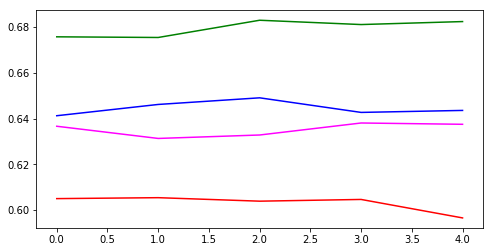

In [15]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['acc'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_acc'],color='blue')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_whitening=False,
                                zca_epsilon=1e-06,
                                rotation_range=0,
                                width_shift_range=0.0,
                                height_shift_range=0.0,
                                brightness_range=None,
                                shear_range=0.0,
                                zoom_range=0.0,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=False,
                                vertical_flip=False,
                                rescale=None,
                                preprocessing_function=preprocess,
                                data_format=None,
                                validation_split=0.2,
                                dtype=None,
                            )

test_set = train_datagen.flow_from_dataframe(
                                            dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            validate_filenames=True
                                        )
